C:\Users\nxf09622\AppData\Local\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Number of samples of car images: 6673
Number of samples of noncar images: 8968


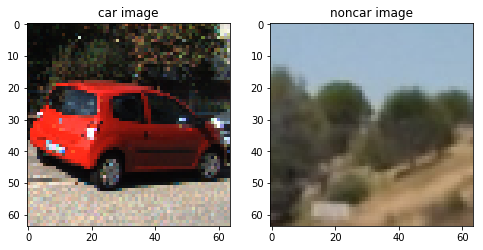

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import cv2
import glob
import time
from core_functions import *
from sklearn.cross_validation import train_test_split

# Read in car images
car_images = glob.glob('./vehicles/KITTI*/*.png')
car_images_GTI = glob.glob('./vehicles/GTI*/*.png')
car_images.extend(car_images_GTI[::4]) # only add every 4th image of GTI (to partially avoid temporal series problem)

# Read in noncar images + choose N random samples, where N - number of car image samples
noncar_images = glob.glob('./non-vehicles/*/*.png')

# printing training set
print('Number of samples of car images:', len(car_images))       # 6673
print('Number of samples of noncar images:', len(noncar_images)) # 8968

# equalize number car and noncar datasets
noncar_images = np.random.choice(noncar_images, len(car_images), replace=False)

# display a car and a noncar images
car_ex    = np.uint8(mpimg.imread('./vehicles/KITTI_extracted/1026.png')*255)
noncar_ex = np.uint8(mpimg.imread('./non-vehicles/KITTI/extra1041.png')*255)

plt.figure()
fig, axs = plt.subplots(ncols=2,figsize=(8, 4))
axs[0].imshow(car_ex)
axs[0].set_title('car image')
axs[1].imshow(noncar_ex)
axs[1].set_title('noncar image')

In [2]:
### FEATURES SETTINGS
spatial_feat   = True # Spatial features on or off
hist_feat      = True # Histogram features on or off
hog_feat       = True # HOG features on or off
color_space    = 'YCrCb'

# spatial features
spatial_size   = (24, 24) # Spatial binning dimensions

# HOG
ch0 = hog_channels.CH0
ch1 = hog_channels.CH1
ch2 = hog_channels.CH2

orient         = 18  # HOG orientations
pix_per_cell   = 16 # HOG pixels per cell
cell_per_block = 1  # HOG cells per block
hog_channel    = (ch0 | ch1 | ch2) # Can be any bitwise combination of ch0, ch1, ch210

# histogram
hist_bins      = 24 # Number of histogram bins

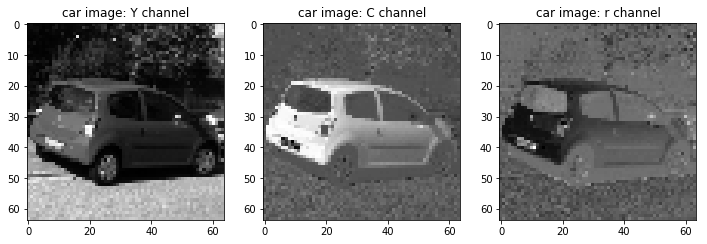

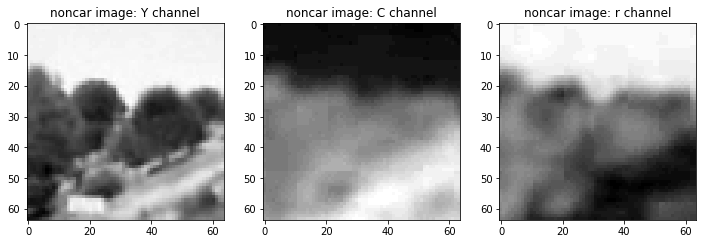

In [10]:
# Display example images in selected colorspace (+ resized)
if color_space != 'RGB':
    car_ex    = cv2.cvtColor(car_ex, eval('cv2.COLOR_RGB2'+color_space))
    noncar_ex = cv2.cvtColor(noncar_ex, eval('cv2.COLOR_RGB2'+color_space))

plt.figure(0)
fig, axs = plt.subplots(ncols=3,figsize=(12,4))
for i in range(3):
    axs[i].imshow(car_ex[:,:,i],'gray')
    axs[i].set_title('car image: {} channel'.format(color_space[i]))

plt.figure(1)
fig, axs = plt.subplots(ncols=3,figsize=(12,4))
for i in range(3):
    axs[i].imshow(noncar_ex[:,:,i],'gray')
    axs[i].set_title('noncar image: {} channel'.format(color_space[i]))

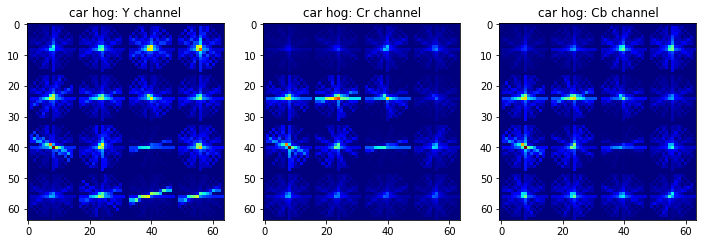

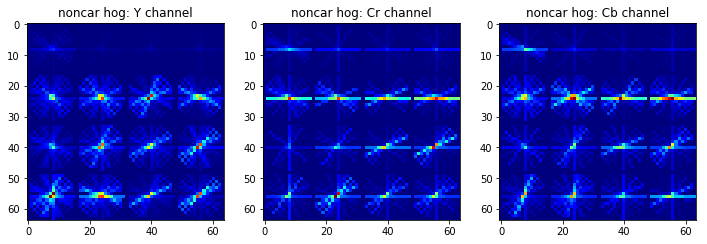

In [11]:
# Display HOG of example images
plt.figure(0)
color_name = ['Y','Cr','Cb']
fig, axs = plt.subplots(ncols=3,figsize=(12,4))
for i in range(3):
    feat, vis = get_hog_features(car_ex[:,:,i], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    axs[i].imshow(vis, 'jet')
    axs[i].set_title('car hog: {} channel'.format(color_name[i]))

plt.figure(1)
fig, axs = plt.subplots(ncols=3,figsize=(12,4))
for i in range(3):
    feat, vis = get_hog_features(noncar_ex[:,:,i], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    axs[i].imshow(vis, 'jet')
    axs[i].set_title('noncar hog: {} channel'.format(color_name[i]))

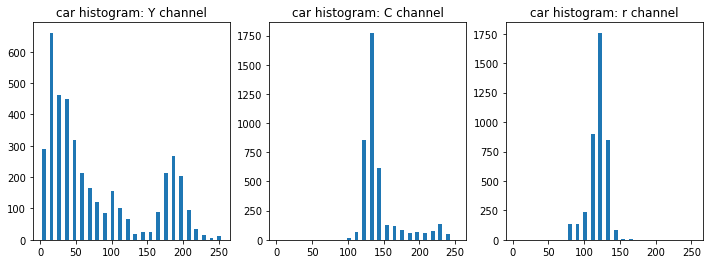

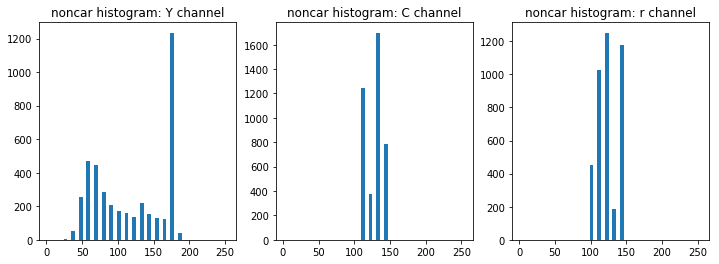

In [6]:
# Display channel histograms of example images
ch0_range, ch1_range, ch2_range = color2bin_range(color_space)
ch0_hist, ch1_hist, ch2_hist = color_hist(car_ex, nbins=hist_bins, 
                                          ch0_range=ch0_range, ch1_range=ch1_range, ch2_range=ch2_range)[1:]
plt.figure(0)
fig, axs   = plt.subplots(ncols=3,figsize=(12,4))
for i in range(3):
    ch_hist     = eval('ch{}_hist'.format(i))
    bin_edges   = ch_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    axs[i].bar(bin_centers, ch_hist[0], width=(bin_edges[1]-bin_edges[0])*0.5)    
    axs[i].set_title('car histogram: {} channel'.format(color_space[i]))

    
ch0_hist, ch1_hist, ch2_hist = color_hist(noncar_ex, nbins=hist_bins, 
                                          ch0_range=ch0_range, ch1_range=ch1_range, ch2_range=ch2_range)[1:]
plt.figure(1)
fig, axs = plt.subplots(ncols=3,figsize=(12,4))
for i in range(3):
    ch_hist     = eval('ch{}_hist'.format(i))
    bin_edges   = ch_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    axs[i].bar(bin_centers, ch_hist[0], width=(bin_edges[1]-bin_edges[0])*0.5)    
    axs[i].set_title('noncar histogram: {} channel'.format(color_space[i]))


In [7]:
import os

# Function extracts features for complete dataset
def extract_dataset_features(imgs, color_space, 
                             spatial_size, hist_bins,
                             orient, pix_per_cell, cell_per_block, hog_channel,
                             spatial_feat, hist_feat, hog_feat):
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        filename, file_extension = os.path.splitext(file)
        image = np.uint8(mpimg.imread(file)*255)
        
        # extract features for a single file and append to list of feature vectors
        file_features = extract_features(image, color_space=color_space,
                                         spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                         spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(np.concatenate(file_features))
        
    # Return list of feature vectors
    return features

In [8]:
from sklearn.preprocessing import StandardScaler

# Extracting features for car and non-car images
t1=time.time()
car_features = extract_dataset_features(car_images, color_space, 
                                        spatial_size, hist_bins, 
                                        orient, pix_per_cell, cell_per_block, hog_channel, 
                                        spatial_feat, hist_feat, hog_feat)
noncar_features = extract_dataset_features(noncar_images, color_space,
                                           spatial_size, hist_bins, 
                                           orient, pix_per_cell, cell_per_block, hog_channel, 
                                           spatial_feat, hist_feat, hog_feat)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds for features extraction...')

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features))
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
t3 = time.time()
print(round(t3-t2, 2), 'Seconds for stacking features and label vectors...')

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
X = X_scaler.transform(X)
t4 = time.time()
print(round(t4-t3, 2), 'Seconds for feature scaling...')

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
t5 = time.time()
print(round(t5-t4, 2), 'Seconds for dataset splitting...')

109.26 Seconds for features extraction...
0.62 Seconds for stacking features and label vectors...
1.71 Seconds for feature scaling...
0.27 Seconds for dataset splitting...


In [9]:
import sklearn.svm as svm

if spatial_feat:
    print('Spatial features:', spatial_size)
if hog_feat:
    print('HOG: using',orient,'orientations',pix_per_cell,
          'pixels per cell and', cell_per_block,'cells per block')
if hist_feat:
    print('Histogram bin number:', hist_bins)
print('Feature vector length:', len(X_train[0]))

clf = svm.LinearSVC()

# Check the training time for the SVC
t1=time.time()
clf.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t1, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

Spatial features: (24, 24)
HOG: using 18 orientations 16 pixels per cell and 1 cells per block
Histogram bin number: 24
Feature vector length: 2664
7.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9925


In [10]:
import pickle

# save the classifier and scaler
with open('clf.pkl', 'wb') as fid:
    pickle.dump(clf, fid)
        
with open('scaler.pkl', 'wb') as fid:
    pickle.dump(X_scaler, fid)

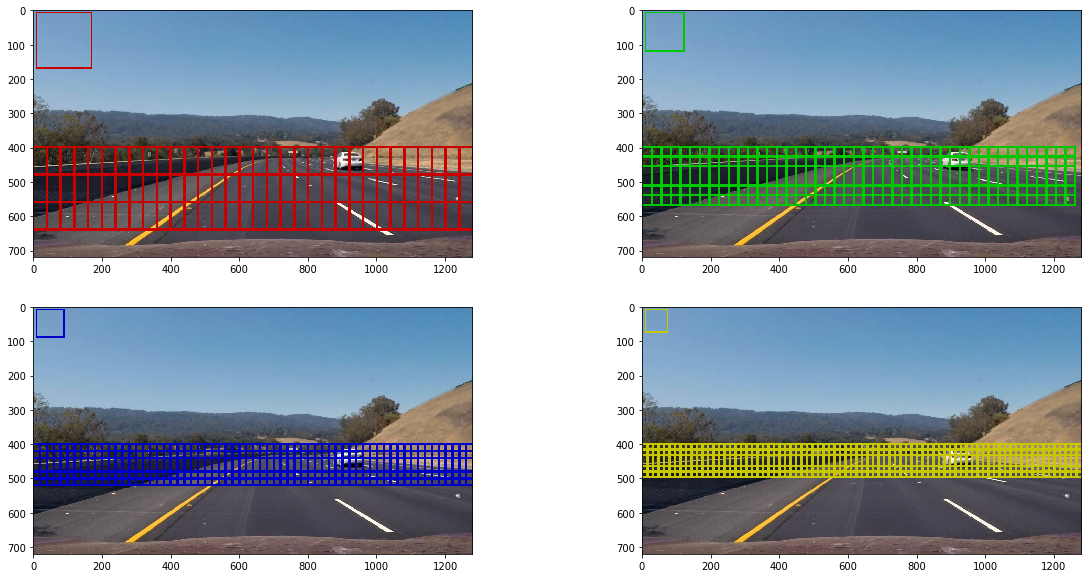

In [21]:
# SLIDING WINDOW PARAMETERS
window_size = [160, 112, 80, 64]
y_min = [400, 400, 400, 400]
y_max = [640, 568, 520, 496]
xy_overlap  = [(0.75, 0.5), (0.75, 0.75), (0.75, 0.75), (0.75, 0.75)] 

# DEMONSTRATION OF SLIDING WINDOWS
bbox_colors = [(200, 0, 0), (0, 200, 0), (0, 0, 200), (200, 200, 0)] # different colors for representation
img = mpimg.imread('./test_images/test3.jpg')
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
for i in range(len(window_size)):
    #plt.figure(i)
    bboxes = slide_window(img, x_start_stop=[None,None], y_start_stop=[y_min[i], y_max[i]], 
                               xy_window=(window_size[i], window_size[i]), xy_overlap=xy_overlap[i])
    box_img = draw_boxes(img, bboxes, color=bbox_colors[i])
    cv2.rectangle(box_img, (10, 10), (10 + window_size[i], 10 + window_size[i]), bbox_colors[i], 3)
    axs[i//2][i%2].imshow(box_img)


In [3]:
# ALTERNATIVE SLIDING WINDOW VIA SCALING (SAME RESULT AS ABOVE)
window_size = 64  
scale = [2.5, 1.75, 1.25, 1.0]
y_min = [400, 400, 400 , 400]
y_max = [640, 568, 520, 496]
xy_overlap  = [(0.75, 0.5), (0.75, 0.75), (0.75, 0.75), (0.75, 0.75)] 

# Return boxes based on sliding window. No heatmap yet.
# utilize global hog estimation.
def car_heatmap(img, classifier, scaler, color_space,
                  spatial_size, hist_bins, hog_channel, orient, pix_per_cell, cell_per_block, 
                  window_size, y_min, y_max, xy_overlap,
                  spatial_feat, hist_feat, hog_feat):
    
    img_h, img_w = img.shape[0:2]
    heatmap = np.zeros((img_h,img_w), dtype=float) # initialization of heatmap
    
    # Convert co correct color space
    if color_space != 'RGB':
        feature_image = cv2.cvtColor(img, eval('cv2.COLOR_RGB2'+color_space))
    else: 
        feature_image = np.copy(img) 
    
    # Identify correct histogram ranges based on color space
    ch0_range, ch1_range, ch2_range = color2bin_range(color_space=color_space)
    
    for i in range(len(scale)):
        cropped_image = feature_image[y_min[i]:y_max[i],:,:]
        if scale[i] != 1.0:
            cv_scale = 1.0/scale[i]
            cropped_image = cv2.resize(cropped_image, (0,0), fx=cv_scale, fy=cv_scale)
        
        # Pixels per step based on overlap
        x_pix_per_step    = np.int(window_size*(1 - xy_overlap[i][0]))
        y_pix_per_step    = np.int(window_size*(1 - xy_overlap[i][1]))
        
        # Number of steps in both dimensions
        nx_steps = np.int((cropped_image.shape[1] - window_size)//x_pix_per_step) + 1
        ny_steps = np.int((cropped_image.shape[0] - window_size)//y_pix_per_step) + 1
    
        # calculate global resized image for spatial features 
        if spatial_feat == True:
            spatial_fx = spatial_size[0]/window_size
            spatial_fy = spatial_size[1]/window_size
            spatial_image = cv2.resize(cropped_image, (0, 0), fx=spatial_fx, fy=spatial_fy)
            # Resized pixels per step for global spatial feature
            x_spix_per_step  = np.int(x_pix_per_step*spatial_fx)
            y_spix_per_step  = np.int(y_pix_per_step*spatial_fy)
           
        # calculate global hog
        if hog_feat == True:
            # Cells per step for HOG and color histogram!
            x_cells_per_step  = np.int(x_pix_per_step//pix_per_cell)
            y_cells_per_step  = np.int(y_pix_per_step//pix_per_cell)
            blocks_per_window = (window_size // pix_per_cell) - cell_per_block + 1
            if (hog_channel & hog_channels.CH0) != 0:
                glob_hog0 = get_hog_features(cropped_image[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=False)
            if (hog_channel & hog_channels.CH1) != 0:
                glob_hog1 = get_hog_features(cropped_image[:,:,1], orient, pix_per_cell, cell_per_block, feature_vec=False)
            if (hog_channel & hog_channels.CH2) != 0:
                glob_hog2 = get_hog_features(cropped_image[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        for xb in range(nx_steps):
            for yb in range(ny_steps):
                features = []
                
                ypos = yb*y_cells_per_step
                xpos = xb*x_cells_per_step
                
                xleft = xpos*pix_per_cell
                ytop  = ypos*pix_per_cell
                window_image = cropped_image[ytop:ytop+window_size, xleft:xleft+window_size,:]
               
                # Spatial features
                if spatial_feat == True:
                    spat_xleft = xb*x_spix_per_step
                    spat_ytop  = yb*y_spix_per_step
                    spatial_features = spatial_image[spat_ytop:spat_ytop + spatial_size[1],
                                                     spat_xleft:spat_xleft + spatial_size[0],:].ravel()
                    #spatial_features = bin_spatial(window_image, spatial_size)
                    features.append(spatial_features)
            
                # Histogram features
                if hist_feat == True:
                    hist_features = color_hist(window_image, nbins=hist_bins, 
                                               ch0_range=ch0_range, ch1_range=ch1_range, ch2_range=ch2_range)[0]
                    features.append(hist_features)
                
                # Extract HOG for this patch
                if hog_feat == True:
                    hog_features = []
                    if (hog_channel & hog_channels.CH0) != 0:
                        hog0_feat = glob_hog0[ypos:ypos+blocks_per_window, xpos:xpos+blocks_per_window].ravel()
                        hog_features.extend(hog0_feat)
                    if (hog_channel & hog_channels.CH1) != 0:
                        hog1_feat = glob_hog1[ypos:ypos+blocks_per_window, xpos:xpos+blocks_per_window].ravel()
                        hog_features.extend(hog1_feat)
                    if (hog_channel & hog_channels.CH2) != 0:
                        hog2_feat = glob_hog2[ypos:ypos+blocks_per_window, xpos:xpos+blocks_per_window].ravel() 
                        hog_features.extend(hog2_feat)
                
                    features.append(hog_features)    
                # Scale features and make a prediction
                scaled_features = scaler.transform(np.concatenate(features).reshape(1, -1))  
                confidence      = classifier.decision_function(scaled_features)
                if (confidence > 0.0):
                    x0 = np.int(xleft*scale[i])
                    y0 = np.int(ytop*scale[i]) + y_min[i]
                    d  = np.int(window_size*scale[i])
                    heatmap[y0:y0+d,x0:x0+d] += confidence**2
    return heatmap

In [4]:
from skimage.filters import threshold_otsu

def heatmap_thresh(heatmap, hard_thres = 1.0, y_min = 0, y_max = 720):
    '''returns heatmap above threshold based on maximum of otsu and hard_thres'''
    # Estimate threshold based on otsu
    try:
        thres   = threshold_otsu(heatmap[y_min:y_max,:], 32) # otsu estimated only on "ACTIVE" part of the image
    except ValueError as e:
        thres   = 1.0
        
    thres = max(thres, hard_thres)
    heatmap[heatmap < thres] = 0
    return heatmap

def heatmap_preproc(heatmap, gaus_kernel=(31,31)):
    res = np.sqrt(heatmap)
    res = cv2.GaussianBlur(res,gaus_kernel,0)
    return res

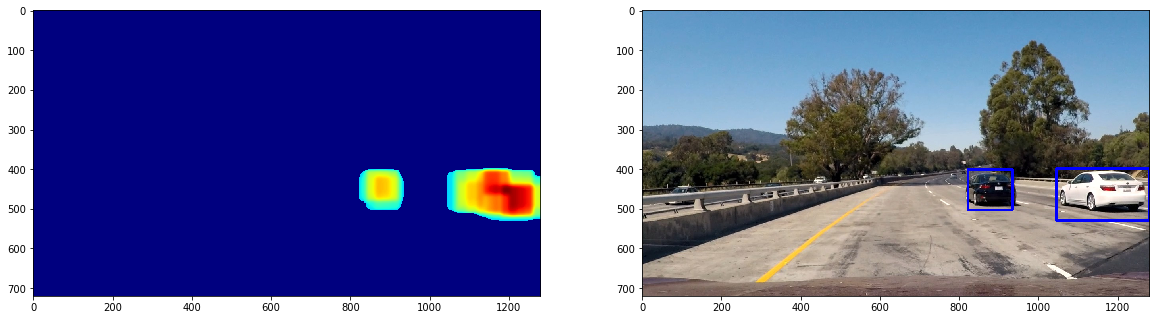

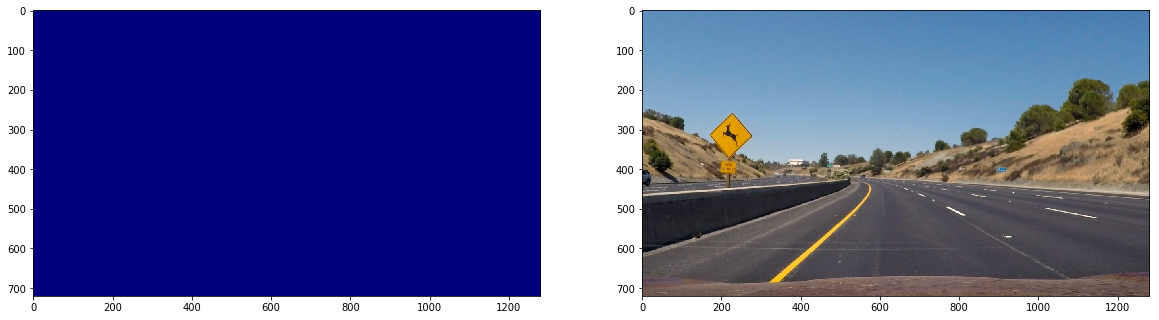

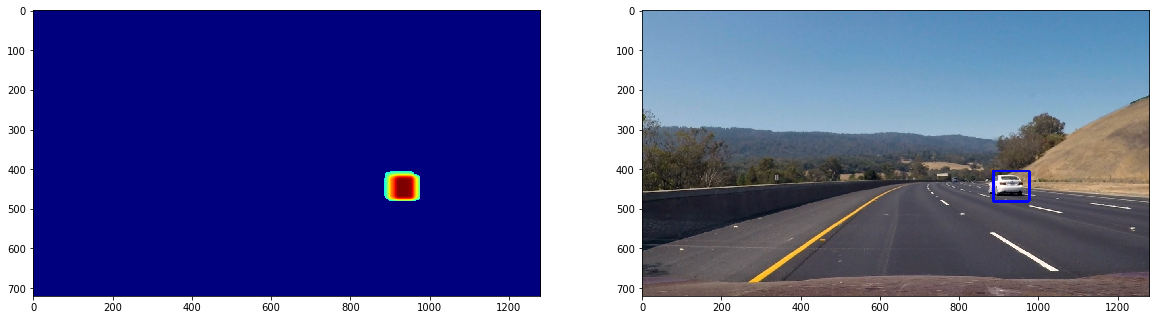

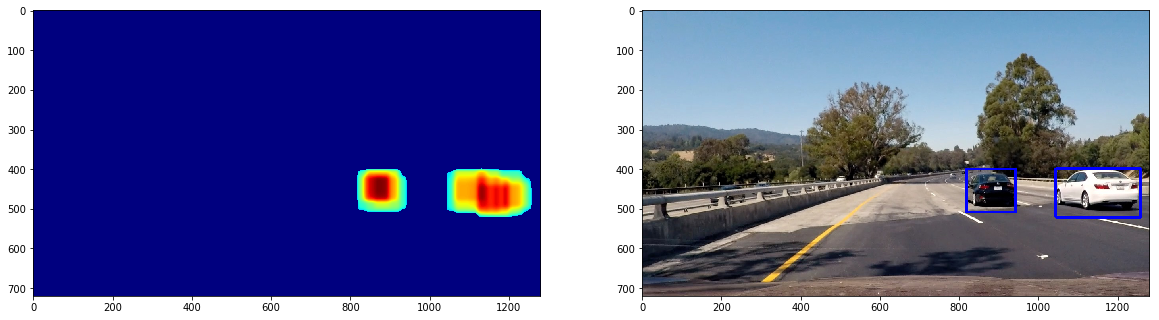

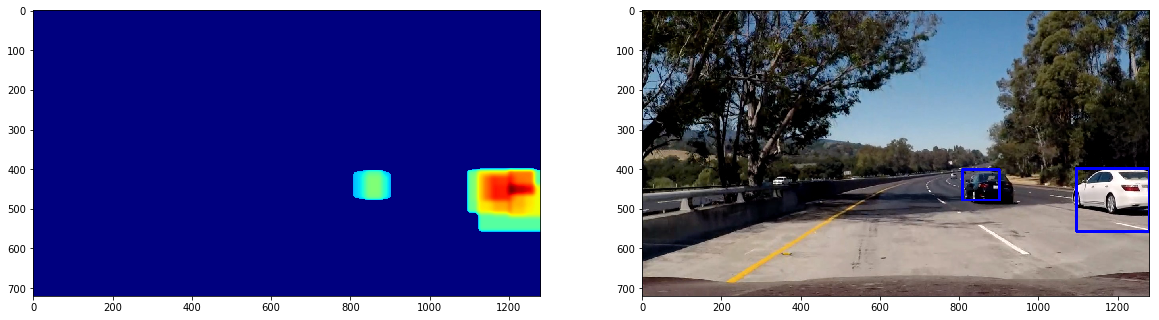

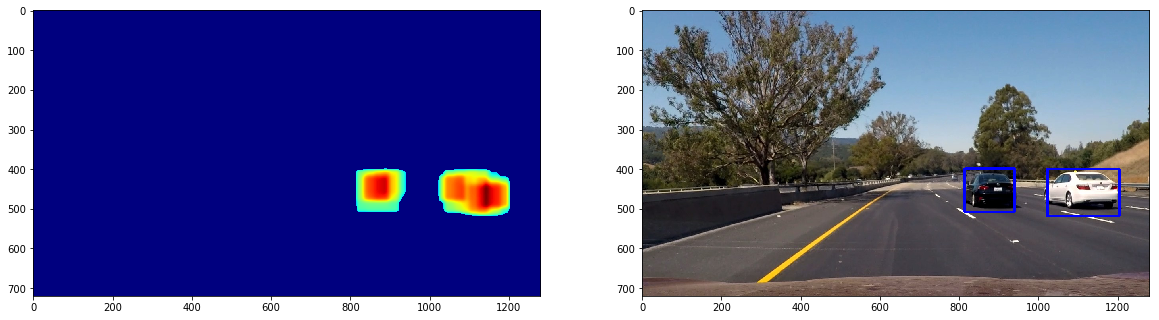

In [18]:
from scipy.ndimage.measurements import label
import core_functions
import pickle
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time

with open('clf.pkl', 'rb') as fid:
    clf = pickle.load(fid)

with open('scaler.pkl', 'rb') as fid:
    scaler = pickle.load(fid)

test_imgs = glob.glob('./test_images/test*.jpg')

for fname in test_imgs:
    image   = mpimg.imread(fname)
    t1      = time.time()  
    heatmap = car_heatmap(image,clf, scaler, color_space,
                              spatial_size, hist_bins, hog_channel, orient, pix_per_cell, cell_per_block, 
                              window_size, y_min, y_max, xy_overlap,
                              spatial_feat, hist_feat, hog_feat)
    # Generating detected box images
    
    # Heatmap normalization and smoothing
    heatmap = heatmap_preproc(heatmap)
    heatmap = heatmap_thresh(heatmap, hard_thres=0.0, y_min = np.min(y_min), y_max = np.max(y_max)) # only apply thresholding for cropped part of the image
    # labels based on thresholded heatmap
    labels = label(heatmap)
    label_img = draw_labeled_bboxes(image, labels)
    # displaying the results
    plt.figure(fname)
    fig, axs = plt.subplots(ncols=2, figsize=(20,10))
    axs[0].imshow(heatmap, cmap='jet')
    axs[1].imshow(label_img)


In [5]:
def heatmap_to_img(heatmap):
    
    norm_heatmap = heatmap
    if np.max(heatmap) != 0:
        norm_heatmap = (heatmap - np.min(heatmap))/np.max(heatmap)
    norm_heatmap = 1 - norm_heatmap
    heatmap_img = cv2.applyColorMap(np.uint8(norm_heatmap*255), cv2.COLORMAP_JET)
    
    return heatmap_img

In [6]:
import pickle
from scipy.ndimage.measurements import label
import core_functions

with open('clf.pkl', 'rb') as fid:
    clf = pickle.load(fid)

with open('scaler.pkl', 'rb') as fid:
    scaler = pickle.load(fid)

### Global variables for video processing
# Decay factor for IIR low-pass filter
alpha = 0.2
# Integrated heatmap
glob_heatmap   = np.zeros((720, 1280), dtype=float)

# Spatio-Temporal correlation settings
ncorr_frame   = 3 # number of correlated frames
last_heatmap  = np.zeros((ncorr_frame,720,1280), dtype=float) # stores heatmaps for last 'corr_frame' frames
frame_cnt     = 0 # frame counter

# function to process video
def process_video(image):
    global glob_heatmap, last_heatmap
    global alpha, ncorr_frame, frame_cnt
    
    label_img = np.copy(image)
   
    # Real-time heatmap of current frame
    last_heatmap[frame_cnt,:,:] = car_heatmap(image,clf,scaler,color_space,
                                              spatial_size, hist_bins, hog_channel, orient, pix_per_cell, cell_per_block,
                                              window_size, y_min, y_max, xy_overlap,
                                              spatial_feat, hist_feat, hog_feat)
    
    # Basic implementation of spatio-temporal correlation across 'ncorr_frame' frames. 
    # Creates a delay of < ncorr_frame, but avoids heatmap spikes:
    # Take the minimum of the last heatmaps (floating equivalent of logical AND). 
    heatmap      = np.amin(last_heatmap,0)
    
    # global heatmap (Infinite Impulse Response Low-Pass Filter)
    glob_heatmap = np.multiply(glob_heatmap, 1.0-alpha) + np.multiply(heatmap, alpha)
    
    # labels based on thresholded heatmap
    res_heatmap = heatmap_thresh(heatmap_preproc(glob_heatmap), hard_thres = 1.0, y_min = np.min(y_min), y_max = np.max(y_max))
    labels = label(res_heatmap)
    
    # Stacking image of current heatmap and global heatmap on image
    # heatmap_img = cv2.resize(heatmap_to_img(last_heatmap[frame_cnt,:,:]),(0,0),fx=0.5,fy=0.5)
    # res_heatmap_img = cv2.resize(heatmap_to_img(res_heatmap),(0,0),fx=0.5,fy=0.5)
    # hm_img = np.hstack((heatmap_img,res_heatmap))
    
    # if vehicles detected (labels count) then draw on image   
    if labels[1] != 0:
        label_img = draw_labeled_bboxes(image, labels)
    
    frame_cnt = (frame_cnt + 1) % ncorr_frame
    return label_img #np.vstack((hm_img,label_img)) 

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_video)
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output42.mp4
[MoviePy] Writing video project_video_output42.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [17:17<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output42.mp4 

Wall time: 17min 21s
